In [711]:
from IPython.core.display import display, HTML

display(HTML("<style>.container { width:100% !important; }</style>")) # Increase cell width
display(HTML("<style>.rendered_html { font-size: 16px; }</style>")) # Increase font size

# Figures
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline  

import pandas as pd
import numpy as np
import itertools
from collections import defaultdict

# Introduction.

This assignment focuses on applying the Feature Engineering processes and the Evaluation methods that we have learned in previous sessions to solve a practical scenario: predict the employees' absenteeism at workplace.

In particular, we are going to use the experimental scenario proposed by the Absenteeism at work Data Set. This dataset includes several explanatory variables  (that may/may not relate to their absence from work) collected for 36 different employees. For more details on the dataset and the competition see 
<https://archive.ics.uci.edu/ml/datasets/Absenteeism+at+work>. 

# Problem Definition.

The main aim is to **predict whether or not an individual is going to have a long absence** (`Absenteeism` variable) it's therefore a binary classification problem.

To faliciatate this, different steps must be covered:

1. Cleaning- Dealing with errors, missing values, etc. 
2. Feature Engineering- Using filter wrapping and embedded methods to imoprove the analysis. 
3. Evaluation Metrics- Applying evaluation metrics in a clear and concise manner in order to solve the problem with the best possible model. 

# Useful Functions

The following fucntions are being created so that they can be called later one without having to create them everytime. 


In [712]:
from sklearn import linear_model
from sklearn.model_selection import cross_val_score, cross_val_predict, cross_validate
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import OneHotEncoder

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix',cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap, aspect='auto')
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    
    plt.xticks(tick_marks, classes.tolist(), rotation=45)
    plt.yticks(tick_marks, classes.tolist())
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 verticalalignment='center',
                 color="white" if cm[i, j] > thresh else "black")

    plt.xlim(-0.5, len(classes)-0.5)
    plt.ylim(len(classes)-0.5, -0.5)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def train_model(X,y, model, show_figures=True): 
    y_pred = cross_val_predict(model, X, y, cv=5)
    conf_mat = confusion_matrix(y, y_pred)
    score = accuracy_score(y,y_pred)
    print("Accuracy = {0:.4f}".format(score))
    if show_figures:
        plot_confusion_matrix(conf_mat, y.unique())
        model.fit(X, y)
        get_feature_importance(model, X.columns, n_features=25)
    return model, score

def get_feature_importance(clf, features, n_features):
    feature_importance = abs(clf.coef_[0])
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    sorted_idx = np.argsort(feature_importance)[:n_features]
    pos = np.arange(sorted_idx.shape[0]) + .5

    featfig = plt.figure(figsize=(10,10))
    featfig.suptitle(str(n_features) + " Most important features")
    featax = featfig.add_subplot(1, 1, 1)
    featax.barh(pos, feature_importance[sorted_idx], align='center')
    featax.set_yticks(pos)
    featax.set_xticks([])
    featax.set_yticklabels(np.array(features)[sorted_idx], fontsize=15)
    featax.set_xlabel('Relative Feature Importance', fontsize=15)
    plt.show()

## 1. Data Reading and preparation

The dataset is offered in two separated fields, one for the training and another one for the test set. Both the datasets are first laoded. 

In [713]:
import pandas as pd

training = pd.read_csv("Absenteeism_at_work_classification_training.csv", delimiter=";", decimal=".")
test = pd.read_csv("Absenteeism_at_work_classification_test.csv", delimiter=";", decimal=".")

To avoid applying the cleaning process two times (once for training and once for test),we apply feature engineering and then split the datasets. However, if we try to do join the two dataframes as they are, we will get an error because they do not have the same columns: `test` does not have a column for the target feature `Absenteeism`. Therefore, we first create this column in the test set and then join the data.

In [714]:
test['Absenteeism'] = 0
dataset = training.append(test)

Let's now visualize the dataset to see where to begin.

In [715]:
pd.options.display.max_columns = dataset.shape[1] # It prints the info in all the columns

dataset.describe()

,ID,Reason.for.absence,Month.of.absence,Day.of.the.week,Seasons,Transportation.expense,Distance.from.Residence.to.Work,Service.time,Age,Work.load.Average.day,Hit.target,Disciplinary.failure,Education,Son,Social.drinker,Social.smoker,Pet,Weight,Height,Body.mass.index,ID.Worker,Absenteeism
count,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000
mean,370.500000,19.216216,6.324324,3.914865,2.544595,221.329730,29.631081,12.554054,36.450000,271.490235,94.587838,0.054054,1.291892,1.018919,0.567568,0.072973,0.745946,79.035135,172.114865,26.677027,18.017568,0.294595
std,213.763888,8.433406,3.436287,1.421675,1.111831,66.952223,14.836788,4.384873,6.478772,39.058116,3.779313,0.226277,0.673238,1.098489,0.495749,0.260268,1.318258,12.883211,6.034995,4.285452,11.021247,0.456169
min,1.000000,0.000000,0.000000,2.000000,1.000000,118.000000,5.000000,1.000000,27.000000,205.917000,81.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,56.000000,163.000000,19.000000,1.000000,0.000000
25%,185.750000,13.000000,3.000000,3.000000,2.000000,179.000000,16.000000,9.000000,31.000000,244.387000,93.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,69.000000,169.000000,24.000000,9.000000,0.000000
50%,370.500000,23.000000,6.000000,4.000000,3.000000,225.000000,26.000000,13.000000,37.000000,264.249000,95.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,83.000000,170.000000,25.000000,18.000000,0.000000
75%,555.250000,26.000000,9.000000,5.000000,4.000000,260.000000,50.000000,16.000000,40.000000,294.217000,97.000000,0.000000,1.000000,2.000000,1.000000,0.000000,1.000000,89.000000,172.000000,31.000000,28.000000,1.000000
max,740.000000,28.000000,12.000000,6.000000,4.000000,388.000000,52.000000,29.000000,58.000000,378.884000,100.000000,1.000000,4.000000,4.000000,1.000000,1.000000,8.000000,108.000000,196.000000,38.000000,36.000000,1.000000


In [716]:
dataset.dtypes

ID                                   int64
Reason.for.absence                   int64
Month.of.absence                     int64
Day.of.the.week                      int64
Seasons                              int64
Transportation.expense               int64
Distance.from.Residence.to.Work      int64
Service.time                         int64
Age                                  int64
Work.load.Average.day              float64
Hit.target                           int64
Disciplinary.failure                 int64
Education                            int64
Son                                  int64
Social.drinker                       int64
Social.smoker                        int64
Pet                                  int64
Weight                               int64
Height                               int64
Body.mass.index                      int64
ID.Worker                            int64
Absenteeism                          int64
dtype: object

We can see a problem by just taking a look to the summary: there are some categorical columns codified as numeric (including the target feature `Absenteeism`). In adddition we notice that the 'max' values of some features have a 'max' value more than 3sds from the mean. We can check them in the upcoming steps. 

## 1. Data Cleaning. 


### 1.1 Changing data from numerical to categorical

In [717]:
categorical_columns = ['ID', 'ID.Worker','Reason.for.absence', 'Month.of.absence', 'Day.of.the.week', 'Seasons', 'Disciplinary.failure', 'Social.drinker', 'Social.smoker', 'Absenteeism']

dataset[categorical_columns] = dataset[categorical_columns].astype("category")
dataset.dtypes

ID                                 category
Reason.for.absence                 category
Month.of.absence                   category
Day.of.the.week                    category
Seasons                            category
Transportation.expense                int64
Distance.from.Residence.to.Work       int64
Service.time                          int64
Age                                   int64
Work.load.Average.day               float64
Hit.target                            int64
Disciplinary.failure               category
Education                             int64
Son                                   int64
Social.drinker                     category
Social.smoker                      category
Pet                                   int64
Weight                                int64
Height                                int64
Body.mass.index                       int64
ID.Worker                          category
Absenteeism                        category
dtype: object

To facilitate the understanding of the feature analysis, we change the name of some of them to their actual meaning (this meaning is in the dataset description file).

In [718]:
reason_for_absence_dict={0:'Infectious parasitic diseases',
                         1:'Neoplasms',
                         2:'Diseases of the blood',
                         3:'Endocrine and metabolic diseases',
                         4:'Mental and behavioural disorders',
                         5:'Diseases of the nervous system',
                         6:'Diseases of the eye and adnexa',
                         7:'Diseases of the ear and mastoid process',
                         8:'Diseases of the circulatory system',
                         9:'Diseases of the respiratory system',
                         10:'Diseases of the digestive system',
                         11:'Diseases of the skin and subcutaneous tissue',
                         12:'Diseases of the musculoskeletal system and connective tissue', 
                         13:'Diseases of the genitourinary system',
                         14:'Pregnancy, childbirth and the puerperium',
                         15:'Certain conditions originating in the perinatal',
                         16:'Congenital malformations, deformations and chromosomal abnormalities',
                         17:'Symptoms, signs and abnormal clinical  findings',
                         18:'Injury, poisoning and certain other consequences of external causes',
                         19:'causes of morbidity and mortality',
                         21:'Factors influencing health status and contact with health services',
                         22:'patient follow-up',
                         23:'medical consultation',
                         24:'blood donation',
                         25:'laboratory examination',
                         26:'unjustified absence',
                         27:'physiotherapy',
                         28:'dental consultation'}

dataset['Reason.for.absence'] = dataset['Reason.for.absence'].replace(reason_for_absence_dict).astype('category')

dataset.Seasons = dataset.Seasons.replace({1:'summer',2:'autumn',3:'winter',4:'spring'}).astype('category')

dataset.Education = dataset.Education.replace({1:'highschool',2:'graduate',3:'postgraduate',4:'master&PhD'}).astype('category')

In [719]:
dataset.dtypes

ID                                 category
Reason.for.absence                 category
Month.of.absence                   category
Day.of.the.week                    category
Seasons                            category
Transportation.expense                int64
Distance.from.Residence.to.Work       int64
Service.time                          int64
Age                                   int64
Work.load.Average.day               float64
Hit.target                            int64
Disciplinary.failure               category
Education                          category
Son                                   int64
Social.drinker                     category
Social.smoker                      category
Pet                                   int64
Weight                                int64
Height                                int64
Body.mass.index                       int64
ID.Worker                          category
Absenteeism                        category
dtype: object

In order to have a baseline to compare the improvements introduced by the feature engineering process, we train a model with the dataset as it is.

### 1.2 Creating the dummified dataset
Finally, since we have numerical and categorical values, we have to dummify the categorical features in the dataset so we can train our ML models. I will also standardize the numerical values

In [720]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler

categorical_cols = dataset.columns[dataset.dtypes=='category'].tolist()
categorical_cols.remove('Absenteeism') # Remove the target variable

# I do not want to include the ID or the ID of the worker
categorical_cols.remove('ID') 
categorical_cols.remove('ID.Worker')
numerical_cols = dataset.columns[dataset.dtypes!='category'].tolist()

ohe = OneHotEncoder()
std_scaler = StandardScaler()
mms = MinMaxScaler()

# Concat the numerical and dummified categorical columns
dummified_dataset = pd.concat([pd.DataFrame(mms.fit_transform(std_scaler.fit_transform(dataset[numerical_cols])), columns=numerical_cols).reset_index(drop=True),                    
                               pd.DataFrame(ohe.fit_transform(dataset[categorical_cols]).toarray(), columns=ohe.get_feature_names(categorical_cols)).reset_index(drop=True),
                               dataset['Absenteeism'].reset_index(drop=True)], axis=1)
dummified_dataset.head(5)

,Transportation.expense,Distance.from.Residence.to.Work,Service.time,Age,Work.load.Average.day,Hit.target,Son,Pet,Weight,Height,Body.mass.index,...,Disciplinary.failure_0,Disciplinary.failure_1,Education_graduate,Education_highschool,Education_master&PhD,Education_postgraduate,Social.drinker_0,Social.drinker_1,Social.smoker_0,Social.smoker_1,Absenteeism
0,0.633333,0.659574,0.428571,0.193548,0.194471,0.842105,0.50,0.125,0.653846,0.272727,0.578947,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0
1,0.000000,0.170213,0.607143,0.741935,0.194471,0.842105,0.25,0.000,0.807692,0.454545,0.631579,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0
2,0.225926,0.978723,0.607143,0.354839,0.194471,0.842105,0.00,0.000,0.634615,0.212121,0.631579,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0
3,0.596296,0.000000,0.464286,0.387097,0.194471,0.842105,0.50,0.000,0.230769,0.151515,0.263158,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0
4,0.633333,0.659574,0.428571,0.193548,0.194471,0.842105,0.50,0.125,0.653846,0.272727,0.578947,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0


### 1.3 Developing a baseline model.

Accuracy = 0.8078


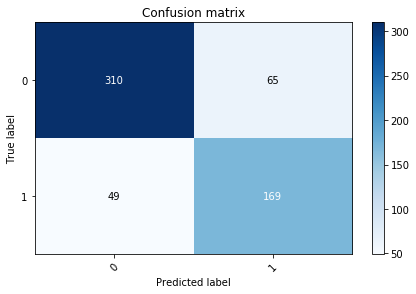

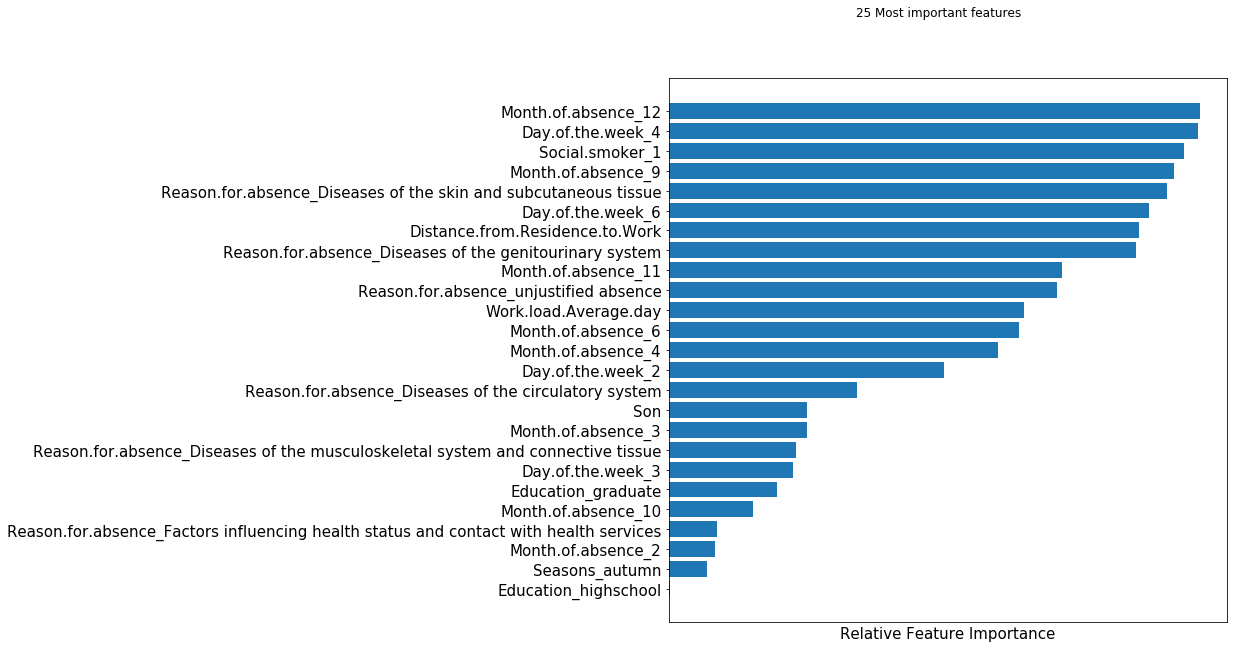

In [721]:
baseline_model, score = train_model(dummified_dataset.iloc[0:593].drop(['Absenteeism'],axis=1), dummified_dataset.iloc[0:593]['Absenteeism'], linear_model.LogisticRegression(max_iter=10000, penalty='none'))

### 1.4 Analysing Outliers.

We will now focus on numerical values. If NULL values are the natural enemy of categorical values, the main problem with numerical values are outliers (values which largely differ from the rest). Outliers can mislead the training of our models resulting in less accurate models and ultimately worse results.

Hence, we identify outliers to then properly deal with them. If we summarize the dataset, we can see variables which "Max." is much larger than the rest of values. These features are susceptible of containing outliers. Nevertheless, the easiest way to detect outliers is visualizing the numerical values; for instance, by `boxploting` the column values.

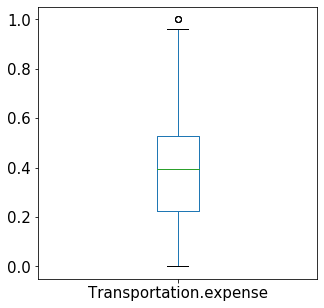

In [722]:
plt.figure(figsize=(5,5))
dummified_dataset.boxplot(['Transportation.expense'], grid=False, fontsize=15)

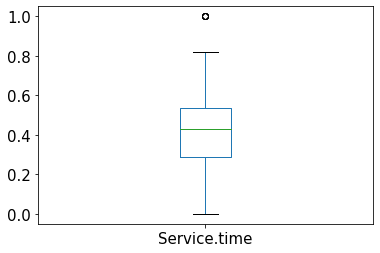

In [723]:
dummified_dataset.boxplot(['Service.time'], grid=False, fontsize=15)

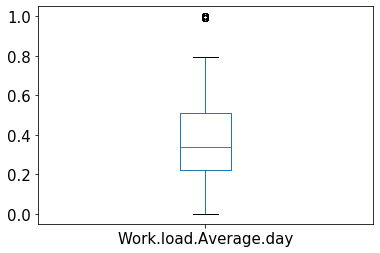

In [724]:
dummified_dataset.boxplot(['Work.load.Average.day'], grid=False, fontsize=15)

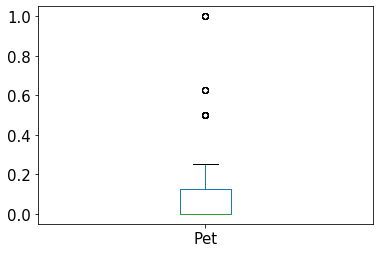

In [725]:
dummified_dataset.boxplot(['Pet'], grid=False, fontsize=15)

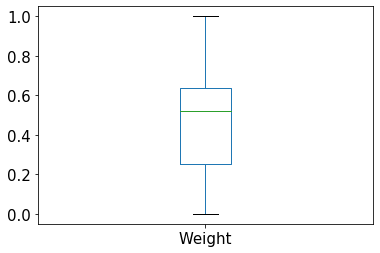

In [726]:
dummified_dataset.boxplot(['Weight'], grid=False, fontsize=15)

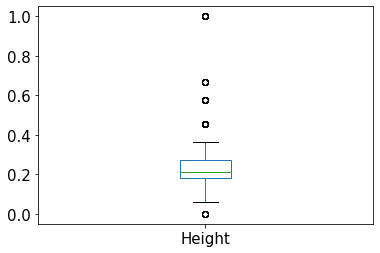

In [727]:
dummified_dataset.boxplot(['Height'], grid=False, fontsize=15)

#### Rationale for choice: 

Having looked at the boxplots of the above selected features, we notice outliers in the variables 'Transportation expense', 'servicetime', 'workloadaverageday', 'pet', 'weight' and 'height'. 
These features were specifically selected after looking at the intial descriptive stats of the entire dataset and based on the statistical intuition that features which have max values more than 3sd away from the mean could be prone to outliers. This is being confirmed by the boxplot test. Hence we proceed to remove outliers in these fields as we do not want our data to follow abnormal trends while training them further. 

### 1.5 Removing outliers

In [728]:
def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    print("{} outliers removed".format(len(df_in)-len(df_out)))
    return df_out

In [729]:
dummified_dataset = remove_outlier(dummified_dataset,'Transportation.expense')
dummified_dataset = remove_outlier(dummified_dataset,'Service.time')
dummified_dataset = remove_outlier(dummified_dataset,'Work.load.Average.day')
dummified_dataset = remove_outlier(dummified_dataset,'Height')
dummified_dataset = remove_outlier(dummified_dataset,'Pet')

3 outliers removed
5 outliers removed
30 outliers removed
107 outliers removed
29 outliers removed


For example, now we in the boxplots of Transportation expense and Pet that there are no significant outliers. 

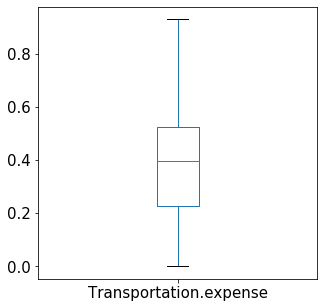

In [730]:
plt.figure(figsize=(5,5))
dummified_dataset.boxplot(['Transportation.expense'], grid=False, fontsize=15)

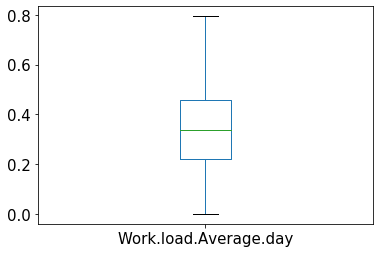

In [731]:
dummified_dataset.boxplot(['Work.load.Average.day'], grid=False, fontsize=15)

### 1.6 Some Advanced factorization to be carried out (if need be). 

Having sucessfully removed outliers, we notice that some feature like 'transport expense', 'Distance.from.Residence.to.Work', 'Service.time' have a huge range of values and can perform more efficiently in ML models when binned to a standard range. 
The present dataset has the following form:

In [732]:
dummified_dataset.describe()

,Transportation.expense,Distance.from.Residence.to.Work,Service.time,Age,Work.load.Average.day,Hit.target,Son,Pet,Weight,Height,Body.mass.index,...,Seasons_winter,Disciplinary.failure_0,Disciplinary.failure_1,Education_graduate,Education_highschool,Education_master&PhD,Education_postgraduate,Social.drinker_0,Social.drinker_1,Social.smoker_0,Social.smoker_1
count,566.000000,566.000000,566.000000,566.000000,566.000000,566.000000,566.000000,566.000000,566.000000,566.000000,566.000000,...,566.000000,566.000000,566.000000,566.000000,566.000000,566.0,566.000000,566.000000,566.000000,566.000000,566.000000
mean,0.371051,0.547741,0.426994,0.299327,0.355574,0.711177,0.260601,0.067138,0.402385,0.210087,0.401339,...,0.192580,0.959364,0.040636,0.035336,0.844523,0.0,0.120141,0.468198,0.531802,0.943463,0.056537
std,0.207661,0.300112,0.121042,0.183555,0.188901,0.205999,0.296174,0.092698,0.241678,0.056288,0.233751,...,0.394674,0.197620,0.197620,0.184790,0.362679,0.0,0.325414,0.499429,0.499429,0.231160,0.231160
min,0.000000,0.000000,0.214286,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.060606,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.225926,0.361702,0.321429,0.137097,0.222412,0.631579,0.000000,0.000000,0.211538,0.181818,0.210526,...,0.000000,1.000000,0.000000,0.000000,1.000000,0.0,0.000000,0.000000,0.000000,1.000000,0.000000
50%,0.396296,0.446809,0.428571,0.322581,0.337244,0.736842,0.250000,0.000000,0.326923,0.212121,0.315789,...,0.000000,1.000000,0.000000,0.000000,1.000000,0.0,0.000000,0.000000,1.000000,1.000000,0.000000
75%,0.525926,0.957447,0.535714,0.387097,0.456365,0.842105,0.500000,0.125000,0.634615,0.242424,0.631579,...,0.000000,1.000000,0.000000,0.000000,1.000000,0.0,0.000000,1.000000,1.000000,1.000000,0.000000
max,0.929630,0.978723,0.821429,1.000000,0.794001,1.000000,1.000000,0.250000,0.961538,0.363636,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000


In [733]:
#dummified_dataset['Distance.from.Residence.to.Work'] = pd.cut(dummified_dataset['Distance.from.Residence.to.Work'], bins=[0, 0.16, 0.32, 0.48, 0.64, 0.80, 1], labels=[0,1,2,3,4,5]).astype('int64')
#dummified_dataset['Age'] = pd.cut(dummified_dataset['Age'], bins=[0, 0.16, 0.32, 0.48, 0.64, 0.80, 1], labels=[0,1,2,3,4,5]).astype('int64')
#dummified_dataset['Hit.target'] = pd.cut(dummified_dataset['Hit.target'], bins=[0, 0.16, 0.32, 0.48, 0.64, 0.80, 1], labels=[0,1,2,3,4,5]).astype('int64')
#dummified_dataset['Weight'] = pd.cut(dummified_dataset['Weight'], bins=[0, 0.16, 0.32, 0.48, 0.64, 0.80, 1], labels=[0,1,2,3,4,5]).astype('int64')
#dummified_dataset['Height'] = pd.cut(dummified_dataset['Height'], bins=[0, 0.16, 0.32, 0.48, 0.64, 0.80, 1], labels=[0,1,2,3,4,5]).astype('int64')
#dummified_dataset['Body.mass.index'] = pd.cut(dummified_dataset['Body.mass.index'], bins=[0, 0.16, 0.32, 0.48, 0.64, 0.80, 1], labels=[0,1,2,3,4,5]).astype('int64')
#dummified_dataset['Transportation.expense'] = pd.cut(dummified_dataset['Transportation.expense'], bins=[0, 0.16, 0.32, 0.48, 0.64, 0.80, 1], labels=[0,1,2,3,4,5]).astype('int64')

In [734]:
#dummified_dataset.head(10)

## 2. Feature Engineering & Model Evaluation.


### 2.1 Feature Creation & Splitting Test-Train datasets. 

In [735]:
from sklearn.model_selection import train_test_split

# 'Absenteeism' is the target variable
X = dummified_dataset.loc[:, dummified_dataset.columns != 'Absenteeism']
y = dummified_dataset['Absenteeism']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [736]:
from sklearn import linear_model
initial_lm_mod = linear_model.LogisticRegression(max_iter=1000, penalty='none')
initial_lm_mod.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='none',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [737]:
def get_feature_importance(clf):
    feature_importance = abs(clf.coef_[0])
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    sorted_idx = np.argsort(feature_importance)
    pos = np.arange(sorted_idx.shape[0]) + .5

    featfig = plt.figure(figsize=(10,18))
    featax = featfig.add_subplot(1, 1, 1)
    featax.barh(pos, feature_importance[sorted_idx], align='center')
    featax.set_yticks(pos)
    featax.set_xticks([])
    featax.set_yticklabels(np.array(X.columns)[sorted_idx], fontsize=12)
    featax.set_xlabel('Relative Feature Importance', fontsize=15)

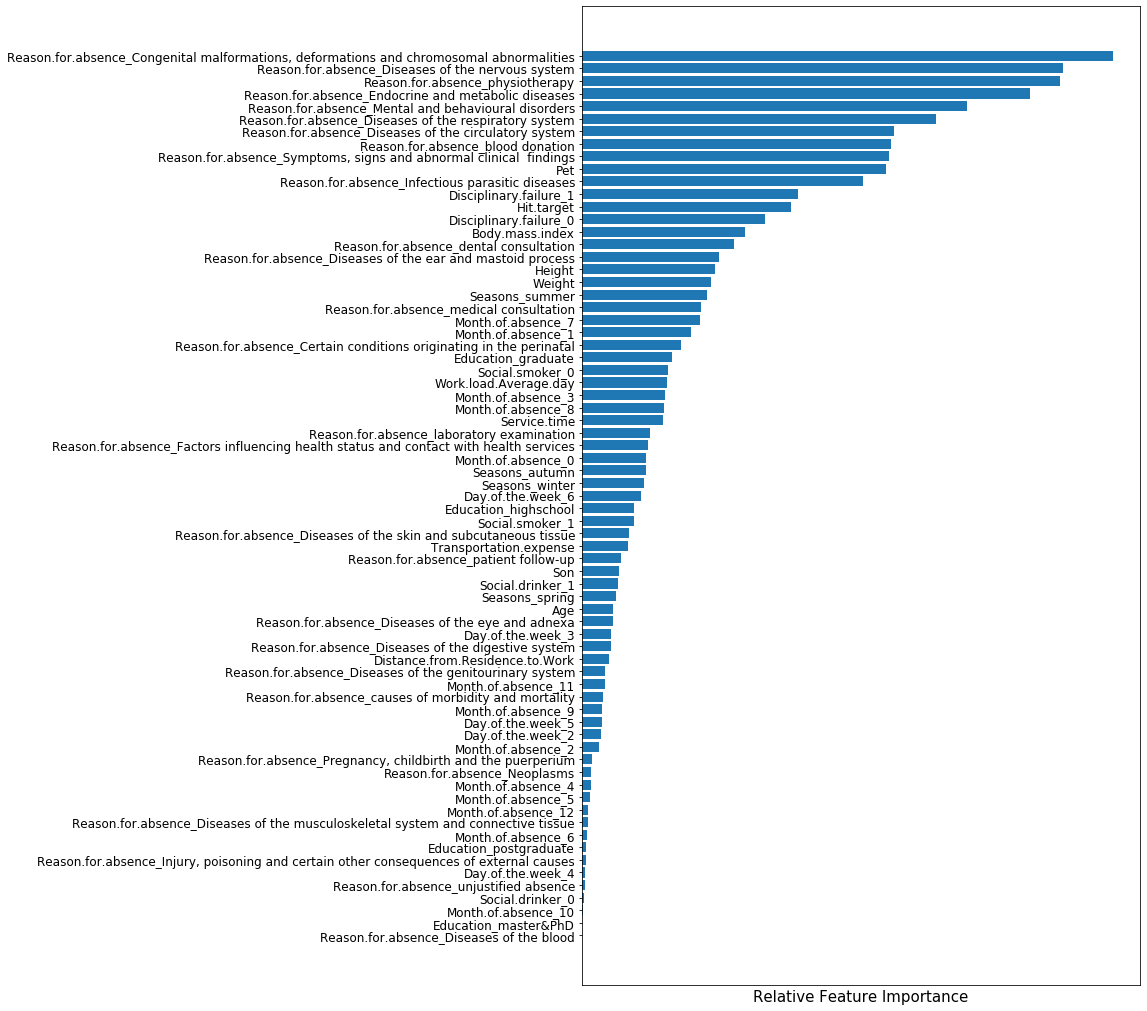

In [738]:
get_feature_importance(initial_lm_mod)

Accuracy = 0.8289


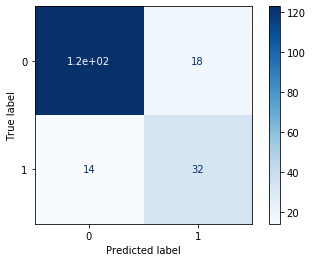

In [739]:
from sklearn.metrics import plot_confusion_matrix, accuracy_score

print("Accuracy = {0:.4f}".format(accuracy_score(y_test,initial_lm_mod.predict(X_test))))
plot_confusion_matrix(initial_lm_mod, X_test, y_test, y_test.unique(), cmap=plt.cm.Blues)


In [740]:
results_df = pd.DataFrame(columns=['Approach', 'Accuracy'])
results_df.loc[len(results_df)] = ['LR Baseline', accuracy_score(y_test,initial_lm_mod.predict(X_test))]
results_df

,Approach,Accuracy
0,LR Baseline,0.828877


The analysis of the confusion matrix points out some interesting aspects:

After having removed all of the outliers, we have an accuracy close to 83% and we are better at predicting class '0' as opposed to calss '1'. But, this ahs a downside, as we removed all the outlier, we have lost around 20% of the data.

### 2.2 Feature Selection & Filtering. 

This dataset is not quite big (at least in w.r.t the number of features, around 20). Nevertheless, it's always a good idea to apply some of the filtering methodologies to remove uninformative features and decide on which ones to focus on to have the best model. 

We rank the features according to their predictive power using the Chi Squared Independence test and the Information Gain.


#### Chi-squared Selection
This helps us measure the relationship between the features and the target feature by using the chi squared selection. We keep those only 'representative enough'.
To automatize this process, removing all the features which ChiSquared score is in the last quartile of the values.

In [741]:
from sklearn.model_selection import train_test_split

X = dummified_dataset.loc[:, dummified_dataset.columns != 'Absenteeism']
y = dummified_dataset['Absenteeism']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

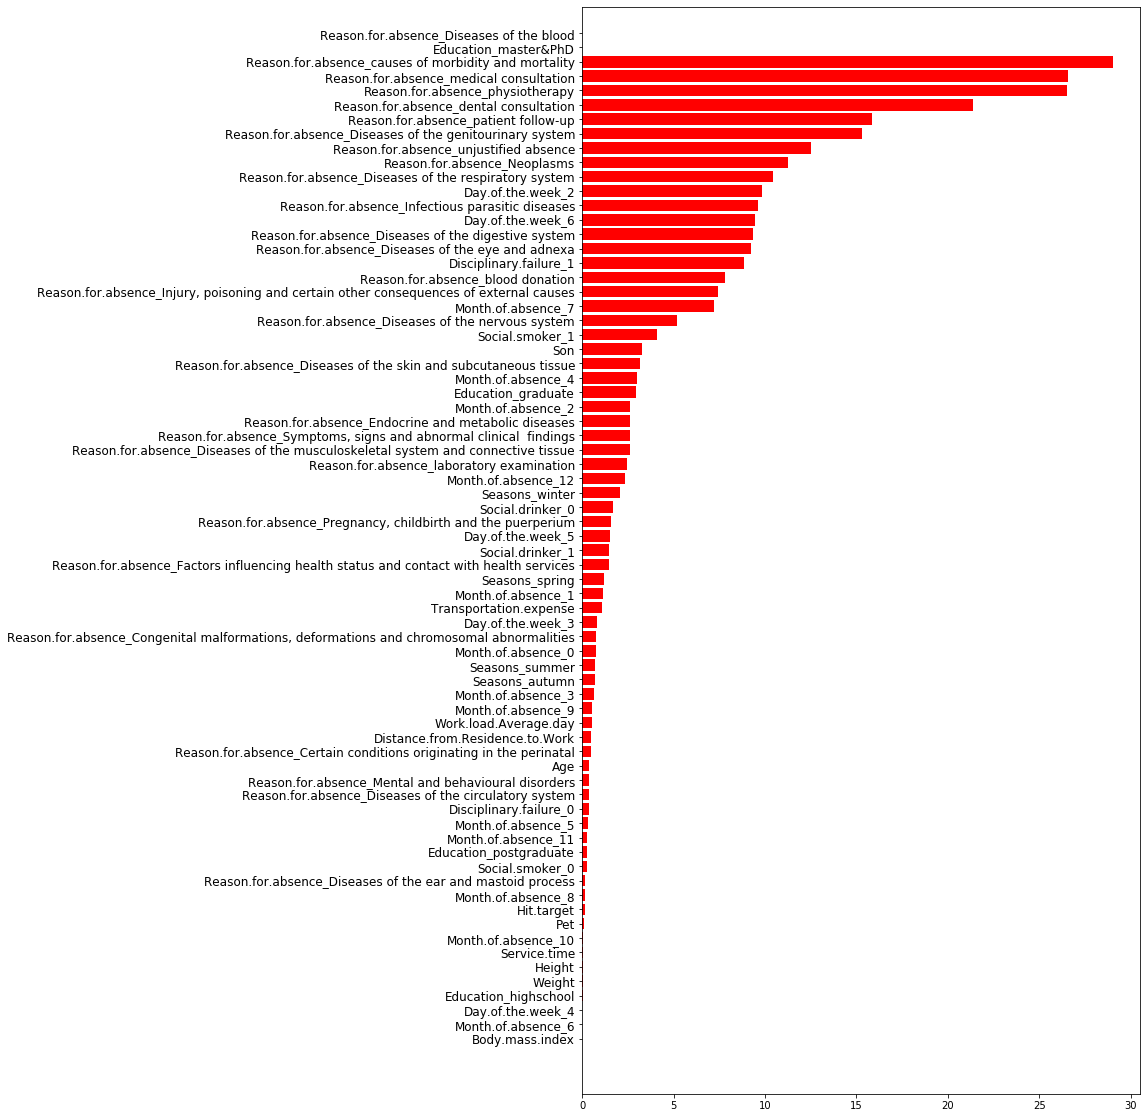

In [742]:
from sklearn.feature_selection import SelectKBest, chi2

chi2_selector = SelectKBest(score_func=chi2).fit(X,y)

# Get the indices sorted by most important to least important
indices = np.argsort(chi2_selector.scores_)[::-1]

chi2_features = []
for i in range(len(X.columns)):
    chi2_features.append(X.columns[indices[i]])

    
# Now plot
plt.figure(figsize=(10,20))
plt.yticks(rotation='horizontal',fontsize=12)
plt.barh(chi2_features, chi2_selector.scores_[indices[range(len(X.columns))]], color='r', align='center')
plt.gca().invert_yaxis()
plt.show()

In [743]:
for i in range(1,len(chi2_features)):
    print("Features used to train the model = {}".format(i))
    print("Accuracy = {0:.4f}".format(accuracy_score(y_test,linear_model.LogisticRegression(max_iter=1000, penalty='none').fit(X_train[chi2_features[:i]], y_train).predict(X_test[chi2_features[:i]]))))
    print()

Features used to train the model = 1
Accuracy = 0.7540

Features used to train the model = 2
Accuracy = 0.7540

Features used to train the model = 3
Accuracy = 0.7807

Features used to train the model = 4
Accuracy = 0.7807

Features used to train the model = 5
Accuracy = 0.7807

Features used to train the model = 6
Accuracy = 0.7807

Features used to train the model = 7
Accuracy = 0.7914

Features used to train the model = 8
Accuracy = 0.8128

Features used to train the model = 9
Accuracy = 0.8128

Features used to train the model = 10
Accuracy = 0.8182

Features used to train the model = 11
Accuracy = 0.7968

Features used to train the model = 12
Accuracy = 0.8075

Features used to train the model = 13
Accuracy = 0.8182

Features used to train the model = 14
Accuracy = 0.7968

Features used to train the model = 15
Accuracy = 0.7968

Features used to train the model = 16
Accuracy = 0.8342

Features used to train the model = 17
Accuracy = 0.8342

Features used to train the model = 18
Ac

In this figure you can see that the threshold is not a very strict threshold (close to 0), this helps us remove all features that are not related at all to the target variable.

Now, we can test if this a good move, by removing any feature with a Chi Squared test statistic equals to 0.


In [744]:
chi2_initial_lm_mod = linear_model.LogisticRegression(max_iter=1000, penalty='none')
chi2_initial_lm_mod.fit(X_train[chi2_features[:20]], y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='none',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [745]:
chi2_features[:20]

['Reason.for.absence_Diseases of the blood',
 'Education_master&PhD',
 'Reason.for.absence_causes of morbidity and mortality',
 'Reason.for.absence_medical consultation',
 'Reason.for.absence_physiotherapy',
 'Reason.for.absence_dental consultation',
 'Reason.for.absence_patient follow-up',
 'Reason.for.absence_Diseases of the genitourinary system',
 'Reason.for.absence_unjustified absence',
 'Reason.for.absence_Neoplasms',
 'Reason.for.absence_Diseases of the respiratory system',
 'Day.of.the.week_2',
 'Reason.for.absence_Infectious parasitic diseases',
 'Day.of.the.week_6',
 'Reason.for.absence_Diseases of the digestive system',
 'Reason.for.absence_Diseases of the eye and adnexa',
 'Disciplinary.failure_1',
 'Reason.for.absence_blood donation',
 'Reason.for.absence_Injury, poisoning and certain other consequences of external causes',
 'Month.of.absence_7']

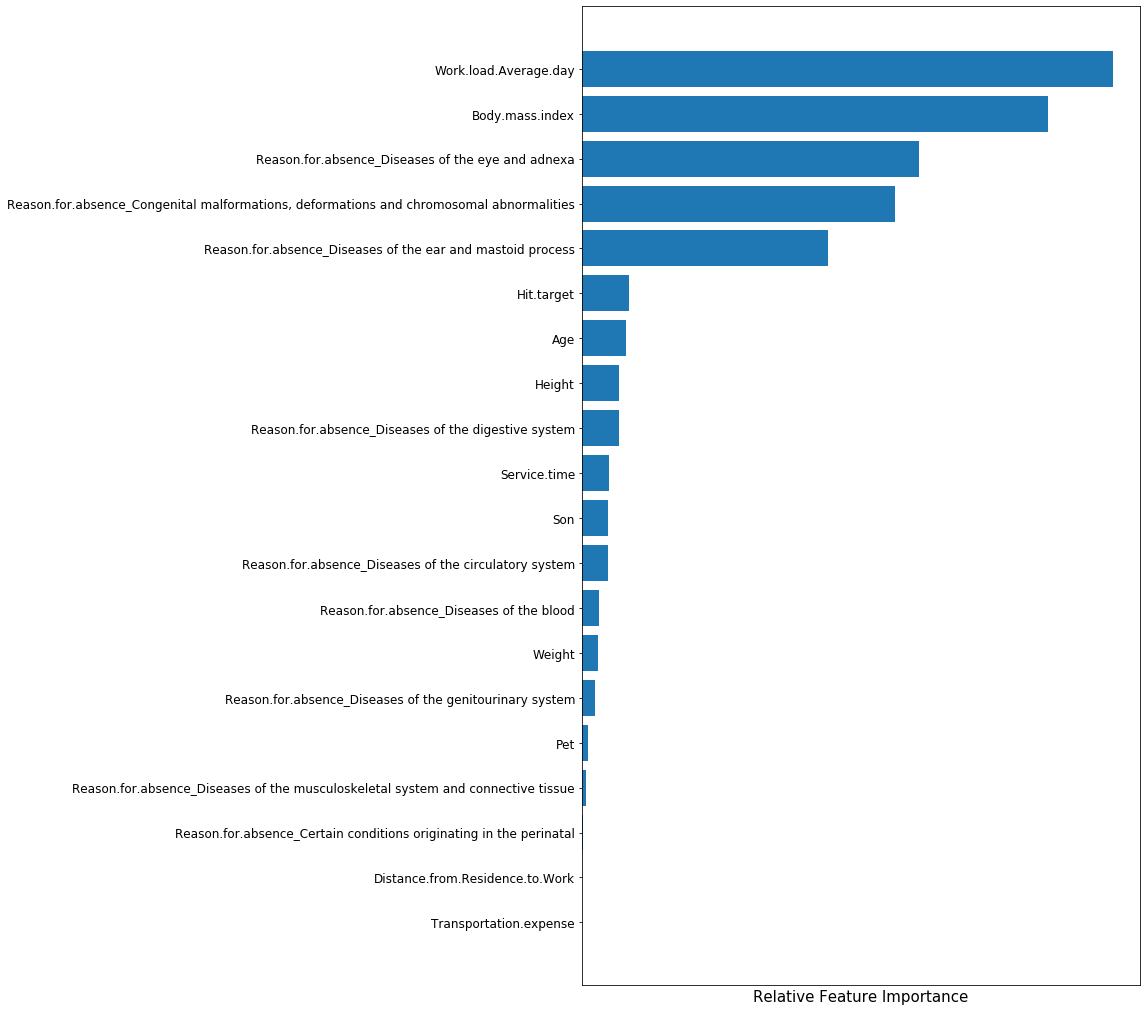

In [746]:
get_feature_importance(chi2_initial_lm_mod)

Having conducted the test on the importance of features, we notice that 20 features related to 'Absenteeism' play an important role and when inspected, they make some business sense. Now, we notice that the accuracy has jumped from 82% to 86% which shows good improvement despiste the loss of data while removing outliers. 

Accuracy = 0.8289


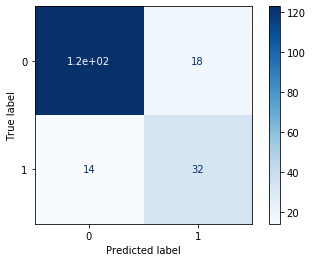

In [747]:
from sklearn.metrics import plot_confusion_matrix, accuracy_score

print("Accuracy = {0:.4f}".format(accuracy_score(y_test,initial_lm_mod.predict(X_test))))
plot_confusion_matrix(initial_lm_mod, X_test, y_test, y_test.unique(), cmap=plt.cm.Blues)

In [748]:
results_df.loc[len(results_df)] = ['LR ChiSquared Selection', accuracy_score(y_test,chi2_initial_lm_mod.predict(X_test[chi2_features[:20]]))]
results_df

,Approach,Accuracy
0,LR Baseline,0.828877
1,LR ChiSquared Selection,0.866310


The score has improved from ~83% to ~87%. 

### 2.3 Model Evaluation.
#### Information Gain Selection

We now try thr information gain selection to compare the results of the chosen variables using chi-squared test and see if this justifies the undertsanding we had earlier. 

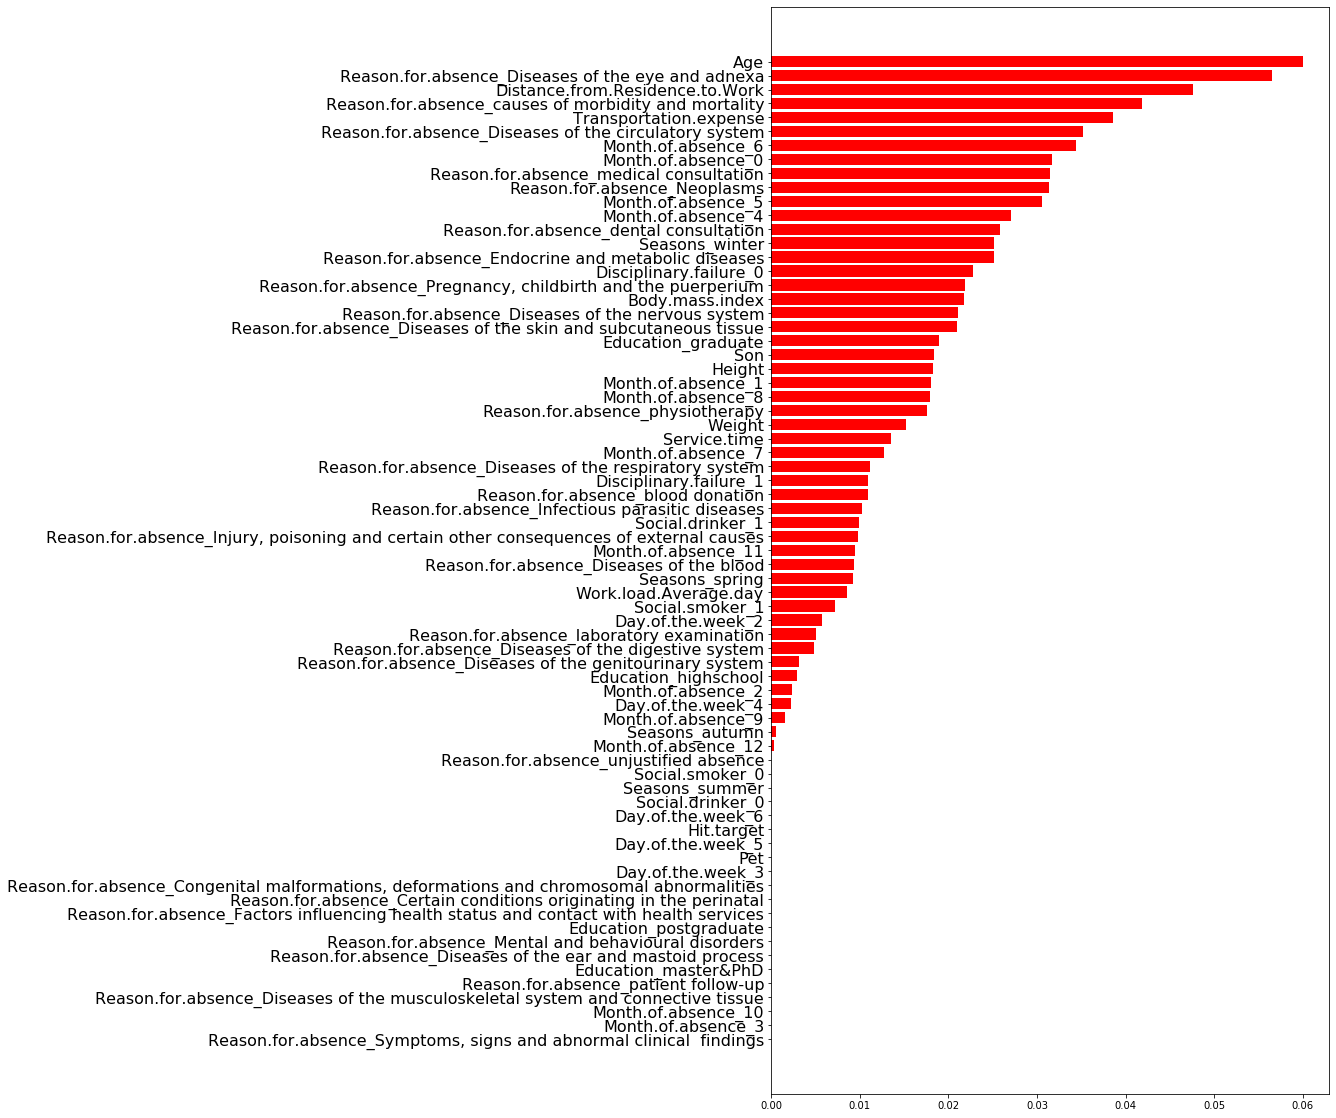

In [749]:
from sklearn.feature_selection import mutual_info_classif

ig_selector = SelectKBest(score_func=mutual_info_classif).fit(X,y)

# Get the indices sorted by most important to least important
indices = np.argsort(ig_selector.scores_)[::-1]

ig_features = []
for i in range(len(X.columns)):
    ig_features.append(X.columns[indices[i]])

# Now plot
plt.figure(figsize=(10,20))
plt.yticks(rotation='horizontal',fontsize=16)
plt.barh(ig_features, ig_selector.scores_[indices[range(len(X.columns))]], color='r', align='center')
plt.gca().invert_yaxis()
plt.show()

In [750]:
for i in range(1,len(ig_features)):
    print("Features used to train the model = {}".format(i))
    print("Accuracy = {0:.4f}".format(accuracy_score(y_test,linear_model.LogisticRegression(max_iter=1000, penalty='none').fit(X_train[ig_features[:i]], y_train).predict(X_test[ig_features[:i]]))))
    print()

Features used to train the model = 1
Accuracy = 0.7540

Features used to train the model = 2
Accuracy = 0.7540

Features used to train the model = 3
Accuracy = 0.7540

Features used to train the model = 4
Accuracy = 0.7807

Features used to train the model = 5
Accuracy = 0.7807

Features used to train the model = 6
Accuracy = 0.7647

Features used to train the model = 7
Accuracy = 0.7647

Features used to train the model = 8
Accuracy = 0.7647

Features used to train the model = 9
Accuracy = 0.7433

Features used to train the model = 10
Accuracy = 0.7487

Features used to train the model = 11
Accuracy = 0.7487

Features used to train the model = 12
Accuracy = 0.7540

Features used to train the model = 13
Accuracy = 0.7647

Features used to train the model = 14
Accuracy = 0.7647

Features used to train the model = 15
Accuracy = 0.7647

Features used to train the model = 16
Accuracy = 0.7647

Features used to train the model = 17
Accuracy = 0.7647

Features used to train the model = 18
Ac

In [751]:
ig_features[:35]
ig_initial_lm_mod = linear_model.LogisticRegression(max_iter=1000, penalty='none')
ig_initial_lm_mod.fit(X_train[ig_features[:35]], y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='none',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

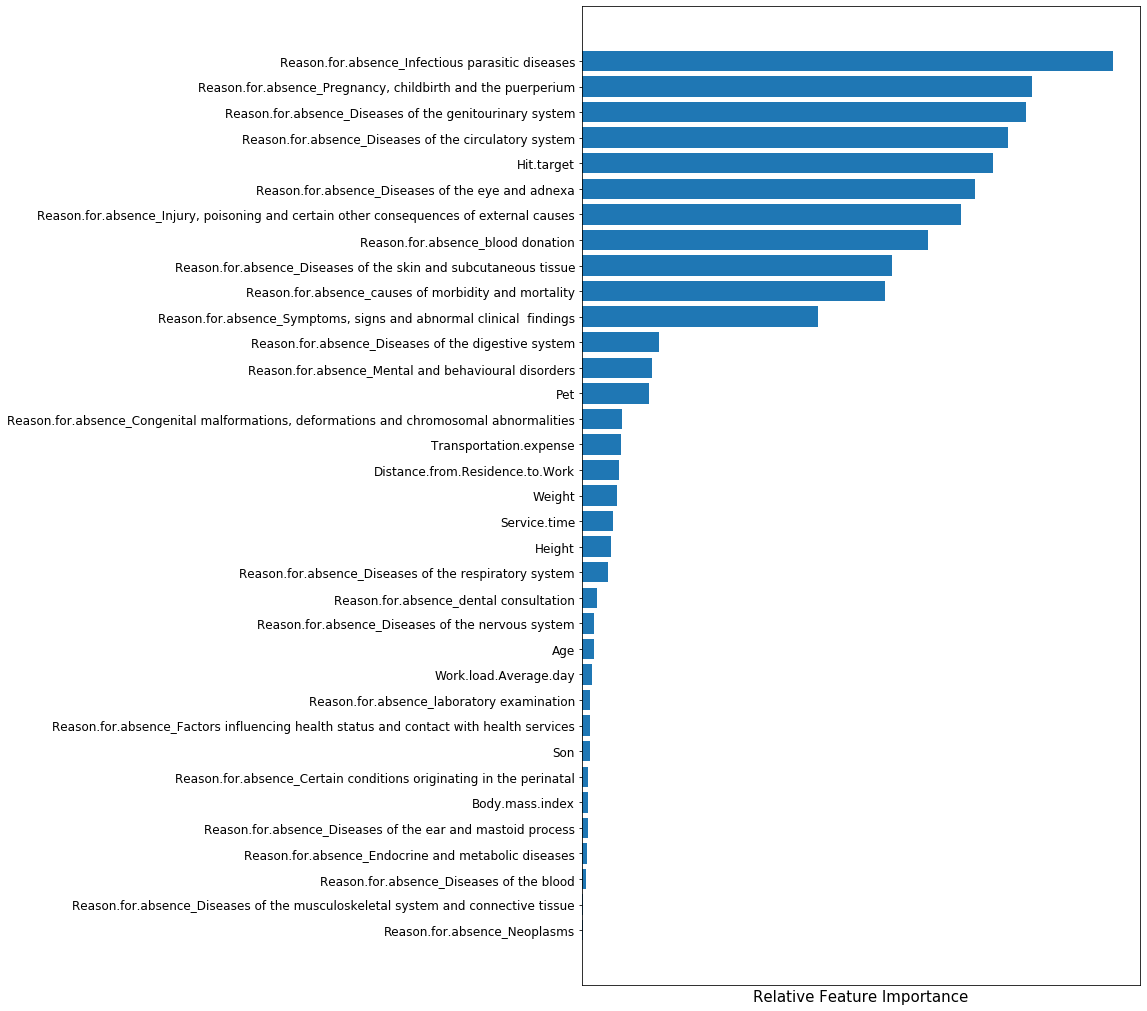

In [752]:
get_feature_importance(ig_initial_lm_mod)

Accuracy = 0.7968


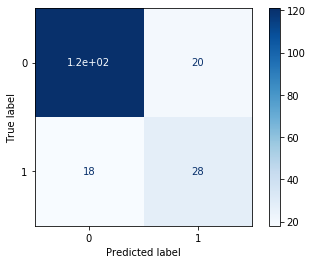

In [753]:
print("Accuracy = {0:.4f}".format(accuracy_score(y_test,ig_initial_lm_mod.predict(X_test[ig_features[:35]]))))
plot_confusion_matrix(ig_initial_lm_mod, X_test[ig_features[:35]], y_test, y_test.unique(), cmap=plt.cm.Blues)

In [754]:
results_df.loc[len(results_df)] = ['LR IG Selection', accuracy_score(y_test,ig_initial_lm_mod.predict(X_test[ig_features[:35]]))]
results_df

,Approach,Accuracy
0,LR Baseline,0.828877
1,LR ChiSquared Selection,0.866310
2,LR IG Selection,0.796791


Having chosen 35 features as recommended by the info gain, we see a slight drop in the accuracy. 15 more features are selected, the model can follow trends which do not exist or true in nature. In such situations, we need to be careful about which decision to make as we might be swayed by the accuracy, this event clearly denotes a drop in accuracy of 3% and increase in the number of features to maximum. This means that we are making the model more flexible by estimating more parameters, can remind us of the cause and effect relationship of overfitting data which esentially means that the model follows the errors or noise too closely. 

#### Embedded
Finally, we will apply embedded methods to create the final model.
#### Ridge

We now try the ridge model. 


In [755]:
ridge_mod = linear_model.LogisticRegression(max_iter=10000,penalty='none')
ridge_mod.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='auto', n_jobs=None, penalty='none',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

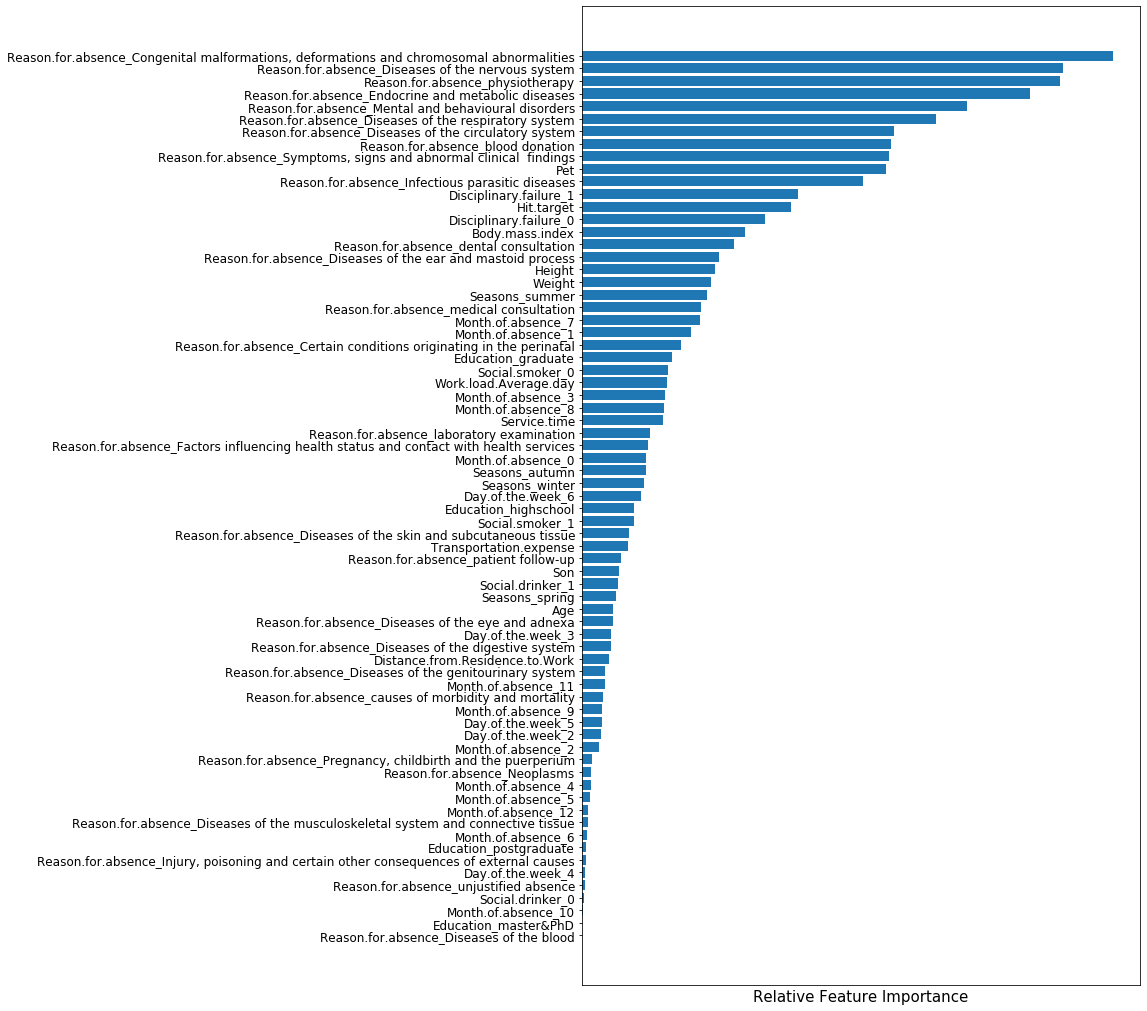

In [756]:
get_feature_importance(ridge_mod)

Accuracy = 0.8289


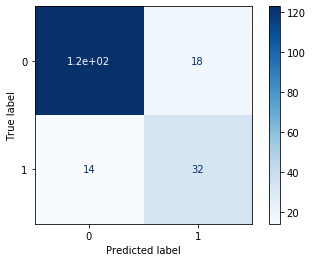

In [757]:
print("Accuracy = {0:.4f}".format(accuracy_score(y_test,ridge_mod.predict(X_test))))
plot_confusion_matrix(ridge_mod, X_test, y_test, y_test.unique(), cmap=plt.cm.Blues)

In [758]:
results_df.loc[len(results_df)] = ['LR Ridge', accuracy_score(y_test,ridge_mod.predict(X_test))]
results_df

,Approach,Accuracy
0,LR Baseline,0.828877
1,LR ChiSquared Selection,0.866310
2,LR IG Selection,0.796791
3,LR Ridge,0.828877


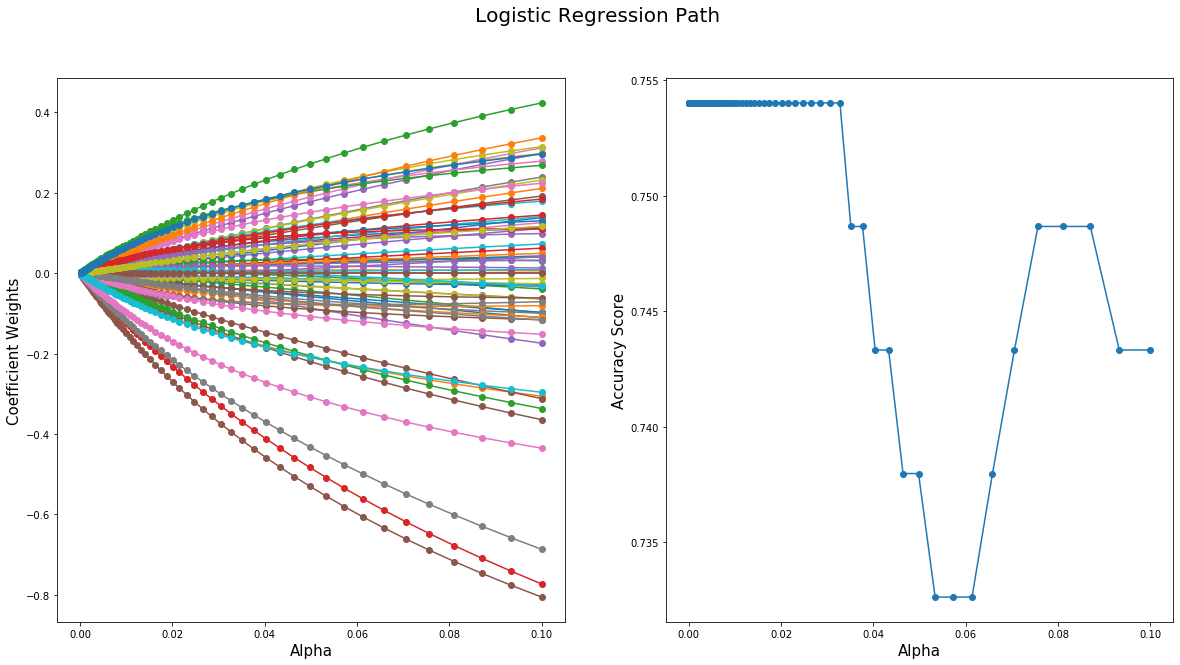

In [759]:
ridge_mod = linear_model.LogisticRegression(max_iter=10000,penalty='l2')
alphas = 10**np.linspace(-1,-4,100)

coefs_ = []
scores_ = []
for a in alphas:
    ridge_mod.set_params(C=a)
    ridge_mod.fit(X_train, y_train)
    coefs_.append(ridge_mod.coef_.ravel().copy())
    scores_.append(accuracy_score(y_test,ridge_mod.predict(X_test)))

coefs_ = np.array(coefs_)
scores_ = np.array(scores_)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
fig.suptitle('Logistic Regression Path', fontsize=20)

# Coeff Weights Plot
ax1.plot(alphas, coefs_, marker='o')
ymin, ymax = plt.ylim()
ax1.set_ylabel('Coefficient Weights', fontsize = 15)
ax1.set_xlabel('Alpha', fontsize = 15)
ax1.axis('tight')

# Accuracy Plot
ax2.plot(alphas, scores_, marker='o')
ymin, ymax = plt.ylim()
ax2.set_ylabel('Accuracy Score', fontsize = 15)
ax2.set_xlabel('Alpha', fontsize = 15)
ax2.axis('tight')

plt.show()

### 2.4 Understanding the Bias-variance trade-off: 

Variance is the amount by which F-estimate would change if we changed the datatset. This optiomal point is often not easily revealed. As shown above, the more flexilbe our model is, the variance increases and bias reduces. More common the model is, lower the variance and higher the bias. In order to minimize the test error, we need a statistixal learning method which achieves low variance and low bias. 

We notice, the smaller the alpha value, the larger the regularization and, consequently, the smaller the weights of the coefficients. There is a trade-off between variance (i.e., less over-fitted model --> more regularization) and bias (i.e., learning more from the training set --> less regularization), cross-validation should be use to find the optimal alpha value. As you can see in the right figure, this value is achieved with small alpha values (i.e., more regularization).



In [760]:
from sklearn.feature_selection import SelectFromModel
alphas = 10**np.linspace(-1,-4,100)

ridge_mod_cv = linear_model.LogisticRegressionCV(max_iter=10000,penalty='l2',Cs=alphas).fit(X_train, y_train)

Accuracy = 0.7487


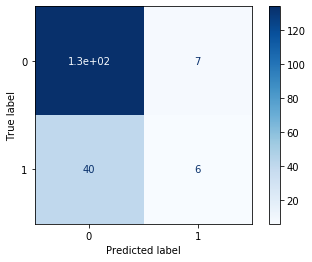

In [761]:
print("Accuracy = {0:.4f}".format(accuracy_score(y_test,ridge_mod_cv.predict(X_test))))
plot_confusion_matrix(ridge_mod_cv, X_test, y_test, y_test.unique(), cmap=plt.cm.Blues)

In [762]:
results_df.loc[len(results_df)] = ['LR CV Ridge', accuracy_score(y_test,ridge_mod_cv.predict(X_test))]
results_df

,Approach,Accuracy
0,LR Baseline,0.828877
1,LR ChiSquared Selection,0.866310
2,LR IG Selection,0.796791
3,LR Ridge,0.828877
4,LR CV Ridge,0.748663


#### Lasso

Let us finally use a cross-validated lasso model and analyze its results



In [763]:
lasso_mod = linear_model.LogisticRegression(penalty='l1', solver='liblinear')
lasso_mod.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

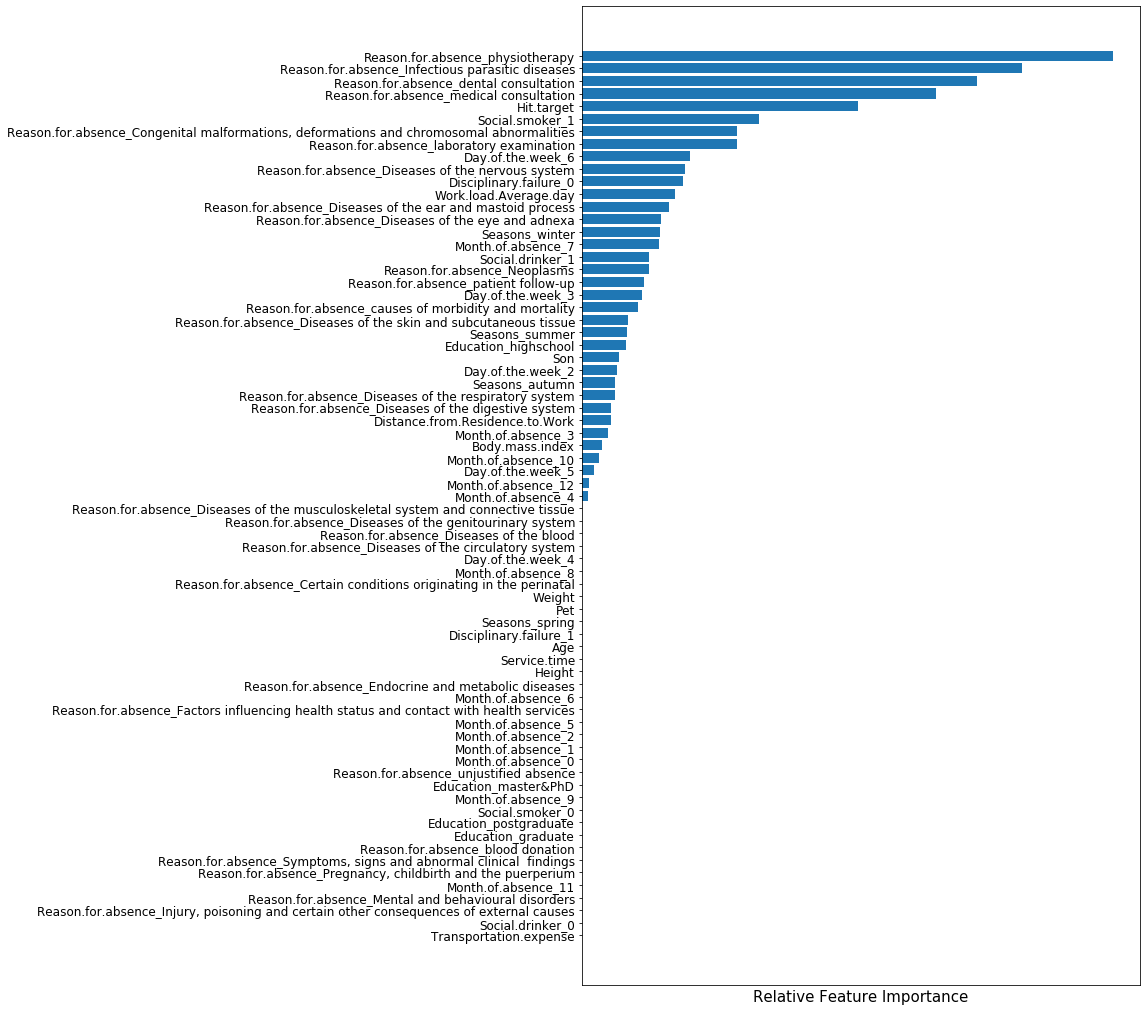

In [764]:
get_feature_importance(lasso_mod)

Accuracy = 0.8289


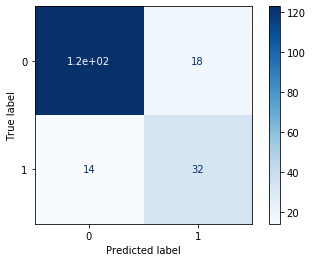

In [765]:
print("Accuracy = {0:.4f}".format(accuracy_score(y_test,lasso_mod.predict(X_test))))
plot_confusion_matrix(lasso_mod, X_test, y_test, y_test.unique(), cmap=plt.cm.Blues)

In [766]:
results_df.loc[len(results_df)] = ['LR Lasso', accuracy_score(y_test,lasso_mod.predict(X_test))]
results_df

,Approach,Accuracy
0,LR Baseline,0.828877
1,LR ChiSquared Selection,0.866310
2,LR IG Selection,0.796791
3,LR Ridge,0.828877
4,LR CV Ridge,0.748663
5,LR Lasso,0.828877


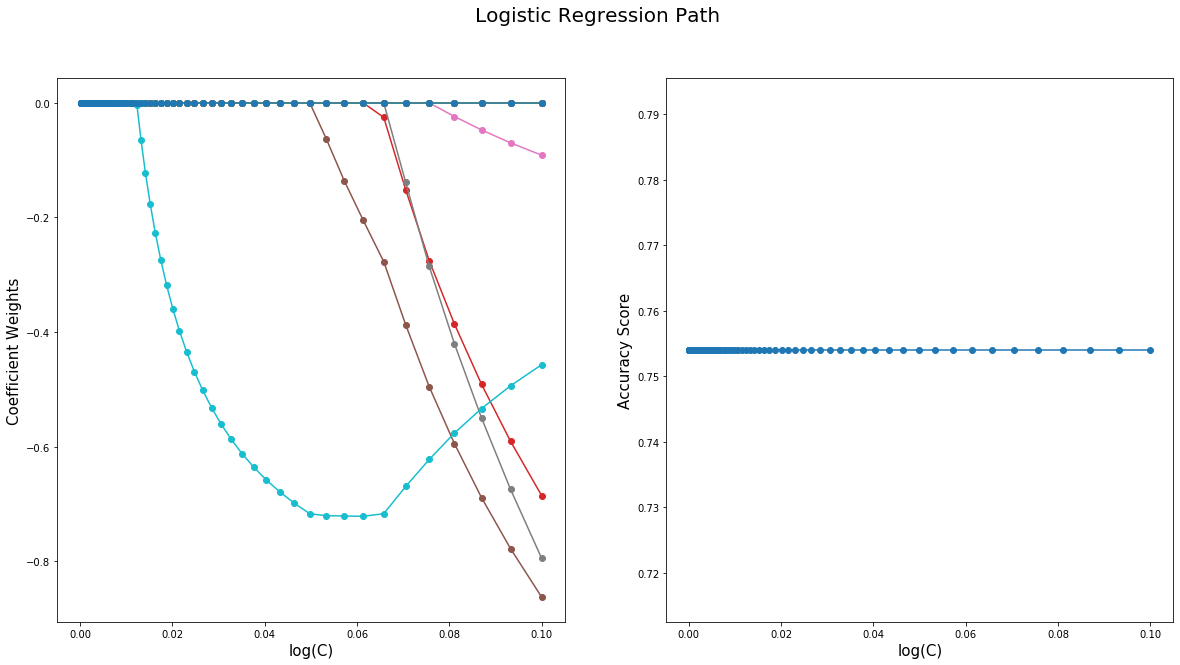

In [767]:
lasso_mod = linear_model.LogisticRegression(penalty='l1',solver='liblinear')
alphas = 10**np.linspace(-1,-4,100)

coefs_ = []
scores_ = []
for a in alphas:
    lasso_mod.set_params(C=a)
    lasso_mod.fit(X_train, y_train)
    coefs_.append(lasso_mod.coef_.ravel().copy())
    scores_.append(accuracy_score(y_test,lasso_mod.predict(X_test)))

coefs_ = np.array(coefs_)
scores_ = np.array(scores_)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
fig.suptitle('Logistic Regression Path', fontsize=20)

# Coeff Weights Plot
ax1.plot(alphas, coefs_, marker='o')
ymin, ymax = plt.ylim()
ax1.set_ylabel('Coefficient Weights', fontsize = 15)
ax1.set_xlabel('log(C)', fontsize = 15)
ax1.axis('tight')

# Accuracy Plot
ax2.plot(alphas, scores_, marker='o')
ymin, ymax = plt.ylim()
ax2.set_ylabel('Accuracy Score', fontsize = 15)
ax2.set_xlabel('log(C)', fontsize = 15)
ax2.axis('tight')

plt.show()

### 2.5 Understanding the trade-off between prediction accuracy and model Interpretability. 

We know that, as the flexibility of a model increases, the interpretability decreases, if we are maily intereted in inference, then restrictive models are much better, when inference is the goal a linear model may be a good choice. But when we are interested in predictiion, the interpretability of the model is often not the focus and we seek to develop an algorithm that predicts our model the best. 

Hence, we would use the moidel that is most flexible and this can again lead to overfitting, as we see above, the Lasso regularization is more abrupt, this because, Lasso tries to nullify the coefficients (Ridge only tries to smooth their values). As a consequence, when regularization is large enough, many coefficient values are close to 0. This needs to be taken care of. 

In [768]:
from sklearn.feature_selection import SelectFromModel

lasso_mod_cv = linear_model.LogisticRegressionCV(max_iter=10000,penalty='l1',solver='liblinear',Cs=alphas).fit(X_train, y_train)

Accuracy = 0.7540


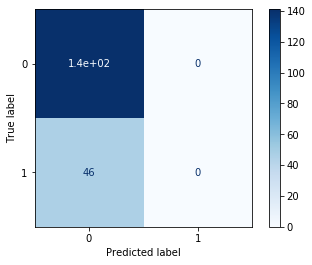

In [769]:
print("Accuracy = {0:.4f}".format(accuracy_score(y_test,lasso_mod_cv.predict(X_test))))
plot_confusion_matrix(lasso_mod_cv, X_test, y_test, y_test.unique(), cmap=plt.cm.Blues)

In [770]:
results_df.loc[len(results_df)] = ['LR CV Lasso', accuracy_score(y_test,lasso_mod_cv.predict(X_test))]
results_df

,Approach,Accuracy
0,LR Baseline,0.828877
1,LR ChiSquared Selection,0.866310
2,LR IG Selection,0.796791
3,LR Ridge,0.828877
4,LR CV Ridge,0.748663
5,LR Lasso,0.828877
6,LR CV Lasso,0.754011


In [771]:
model = SelectFromModel(lasso_mod_cv, prefit=True)
X_new = model.transform(X_train)
X_test_new = model.transform(X_test)
print("Original Number of Features = {} --> Number of features selected by Lasso = {}".format(X_train.shape[1], X_new.shape[1]))

Original Number of Features = 71 --> Number of features selected by Lasso = 5


Accuracy = 0.7594


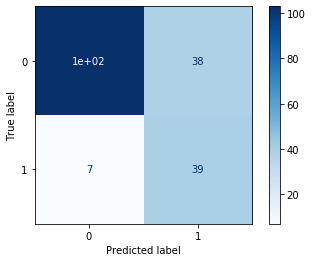

In [772]:
reduced_lasso_mod = linear_model.LogisticRegression(max_iter=10000,penalty='l1', solver='liblinear')
reduced_lasso_mod.fit(X_new, y_train)
print("Accuracy = {0:.4f}".format(accuracy_score(y_test,reduced_lasso_mod.predict(X_test_new))))
plot_confusion_matrix(reduced_lasso_mod, X_test_new, y_test, y_test.unique(), cmap=plt.cm.Blues)

## 3. Final Results. 

In [773]:
results_df.loc[len(results_df)] = ['LR Reduced Lasso', accuracy_score(y_test,reduced_lasso_mod.predict(X_test_new))]
results_df

,Approach,Accuracy
0,LR Baseline,0.828877
1,LR ChiSquared Selection,0.866310
2,LR IG Selection,0.796791
3,LR Ridge,0.828877
4,LR CV Ridge,0.748663
5,LR Lasso,0.828877
6,LR CV Lasso,0.754011
7,LR Reduced Lasso,0.759358


## 4. Conclusions. 

Therefore, it is seen from our ML pipeline that Linear regression with filtering based on ChiSquared Selection has gained us the best model. 
This model has the most minimal number of features with the best accuracy score of ~87%. We can be sure with the current accuracy, TP and FP rate that that the model by virtue of selection of it's features has been optimized to capture the general pattern of the dataset. This can help us handle variations in the dataset with low test errors which in turn helps us deal with the "bias-variance" trade-off. 

In order to maintain a low test MSE, we need a Model  and statistical learning method that can achieve low bias and low variance at the same time.
Variance is a non-negative quantity and therefore the lowes possivle var(e) which will be the irreducible error in any model. Fiding this optimal balance through series of cross validation steps is most important and has been carried out sucessfully in the above steps. 

On the other hand, since the model on average has the low number of features when compared to the rest, i.e, 20, it can take care of the overfitting of data which is noramlly an issue while arriving at prediction models.

Moreover, as a classifier, we know statistically, logistic regression works more effectively for two-class calssification problems and for qualitative variables and variables having more classes (Ref: Introduction to statistixal learning, pg: 130). In our case, we did have more quantitaive variables, but most of them were also categorical and hence taken care of from the data cleaning side. Hence, this model is seen to be performing better in-terms of predicting the probability of each class of the variable which is shown statistically from the tablke of results. 


## 5. Final Submission

The following piece of code takes the final model, creates the predictions for the test set and creates the submission file with the required format (a column with the `ID` and a column with the predictions `"Absenteeism`).

In [774]:
# Train the model using all the data
final_model = chi2_initial_lm_mod

In [775]:
#To make sure the number of featurea in the test and train are the same. 
X_test = X_test[chi2_features[:20]]

In [776]:
#To ensure check for the similarity in features between test and the best model. 
X_test.describe()

,Reason.for.absence_Diseases of the blood,Education_master&PhD,Reason.for.absence_causes of morbidity and mortality,Reason.for.absence_medical consultation,Reason.for.absence_physiotherapy,Reason.for.absence_dental consultation,Reason.for.absence_patient follow-up,Reason.for.absence_Diseases of the genitourinary system,Reason.for.absence_unjustified absence,Reason.for.absence_Neoplasms,Reason.for.absence_Diseases of the respiratory system,Day.of.the.week_2,Reason.for.absence_Infectious parasitic diseases,Day.of.the.week_6,Reason.for.absence_Diseases of the digestive system,Reason.for.absence_Diseases of the eye and adnexa,Disciplinary.failure_1,Reason.for.absence_blood donation,"Reason.for.absence_Injury, poisoning and certain other consequences of external causes",Month.of.absence_7
count,187.0,187.0,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.0,187.000000,187.000000,187.000000,187.000000,187.0,187.000000,187.000000,187.000000,187.000000
mean,0.0,0.0,0.037433,0.208556,0.122995,0.187166,0.042781,0.053476,0.042781,0.016043,0.0,0.187166,0.032086,0.187166,0.037433,0.0,0.026738,0.010695,0.032086,0.064171
std,0.0,0.0,0.190330,0.407367,0.329313,0.391092,0.202906,0.225585,0.202906,0.125977,0.0,0.391092,0.176700,0.391092,0.190330,0.0,0.161750,0.103139,0.176700,0.245715
min,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
25%,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
50%,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
75%,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
max,0.0,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000


In [777]:
# Test prediction
final_pred = final_model.predict(X_test)

In [778]:
final_pred = final_model.predict(X_test)
predictions = pd.DataFrame({'ID':X_test.index, 'Absenteeism.time.in.hours':final_pred})

In [779]:
predictions.to_csv("predictions.csv", index=False)

In [780]:
print("Accuracy = {0:.4f}".format(accuracy_score(y_test,chi2_initial_lm_mod.predict(X_test))))

Accuracy = 0.8663
